In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams["font.family"] = "sans-serif"

In [3]:
df = pd.read_csv("../Tasks/Barcelona airbnb 10.2020.csv")

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


In [5]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365']


                                  Shape and data types of the data

In [6]:
df.shape

(19896, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

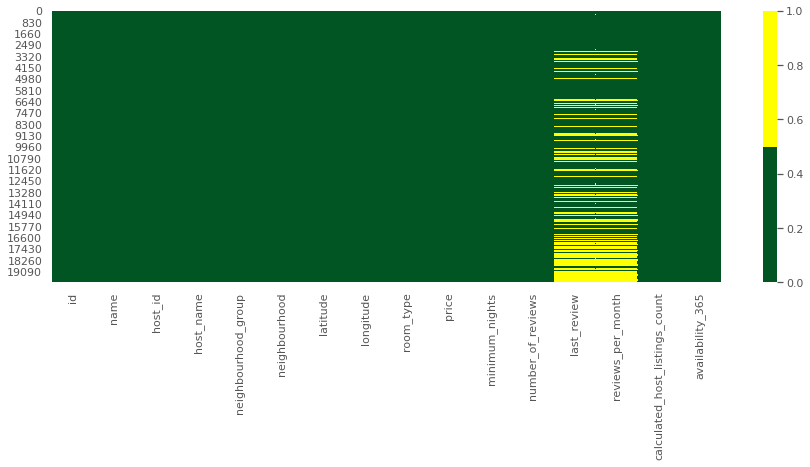

In [11]:
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours));

Диаграмма корреляции для визуального просмотра метрики корреляции между всеми возможными парами числовых переменных в данном наборе данных 

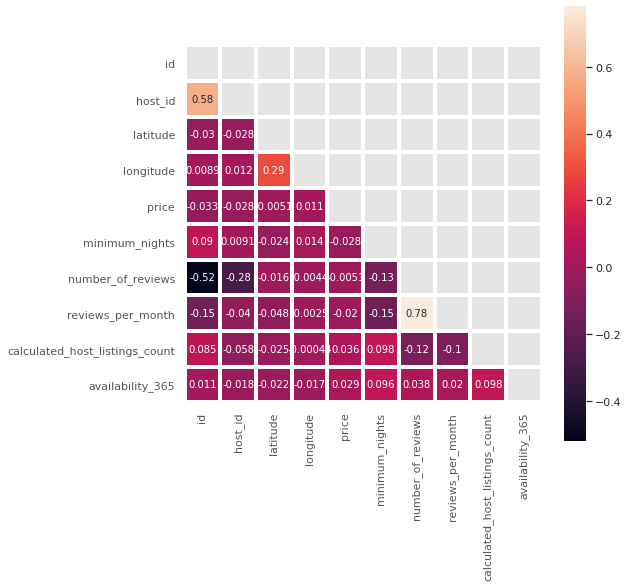

In [12]:
# матрица корреляции между атрибутами объекта
fig, ax = plt.subplots(figsize=(8, 8))
corr = df[[
    'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365'
]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [13]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [14]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [15]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [16]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Нетипичные данные (выбросы)

In [17]:
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [18]:
df['price'].median()

54.0

In [19]:
df['price'].mode()[0]

50

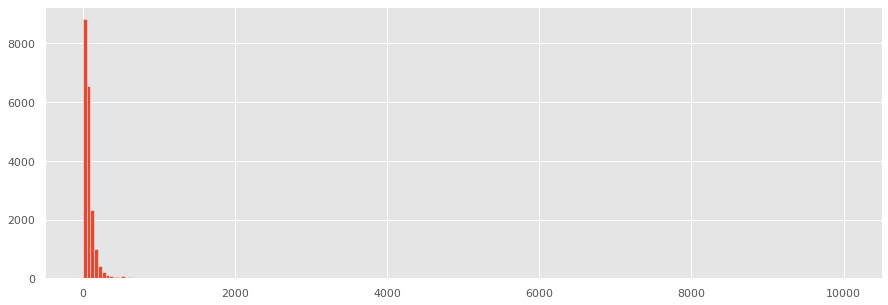

In [20]:
df['price'].hist(bins=200);

Отрицательно-биномиальная распределение

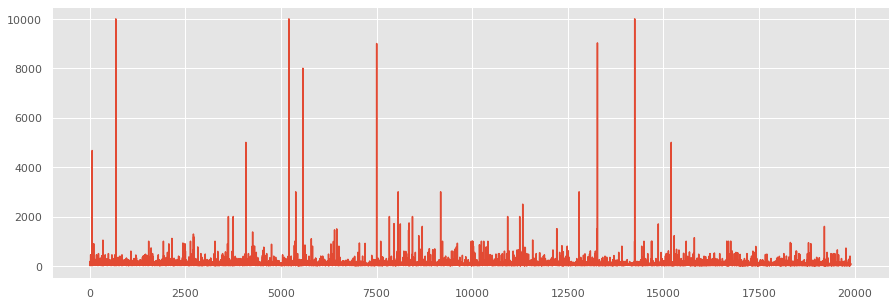

In [21]:
df["price"].plot();

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


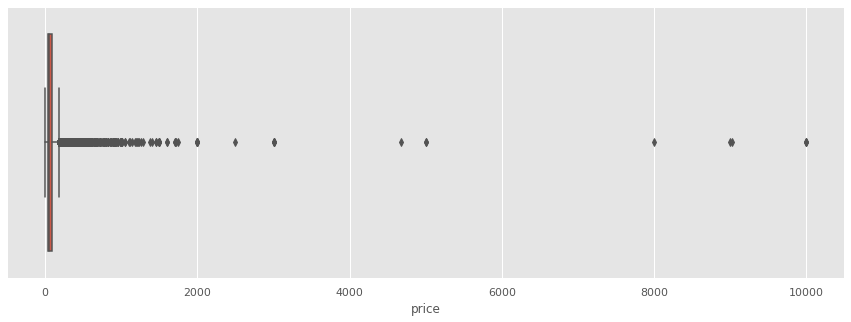

In [22]:
sns.boxplot(df['price'], orient="h");

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


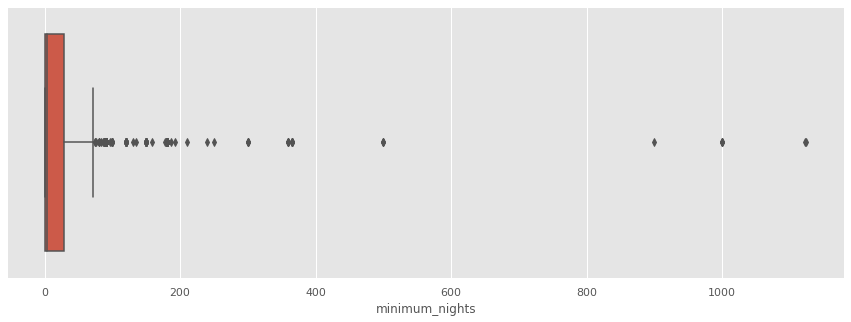

In [23]:
sns.boxplot(df['minimum_nights'], orient="h");

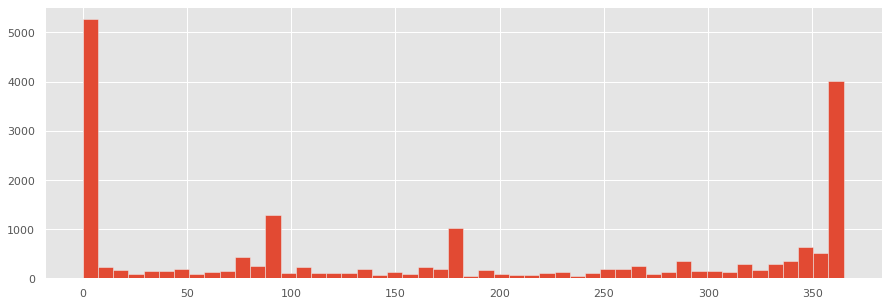

In [24]:
df['availability_365'].hist(bins=50);

In [25]:
filtered_emissions['neighbourhood_group'].value_counts().plot.bar();

NameError: name 'filtered_emissions' is not defined

In [ ]:
df['neighbourhood_group'].value_counts().plot.bar();

In [ ]:
filtered_emissions['neighbourhood_group'].value_counts()

### Качество данных 
насколько данные пригодны для использования

### Неинформативные признаки

In [ ]:
[k for k,v in Counter(df["id"]).items() if v>1]

### Нерелевантные признаки

### Разные форматы данных

In [ ]:
df['last_review_dt'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')

In [ ]:
# Разные регистры символов
df['name'] = df['name'].str.lower() #нижний регистр для всех строк
df['name'] = df['name'].str.strip() #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '') #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b', 'st') # введение сокращения

In [ ]:
df.dtypes

In [ ]:
f, ax = plt.subplots( figsize=(10,10) )
sns.heatmap(df.corr(),annot=True,linewidths=1)
plt.show()

In [ ]:
df.sample(5)

In [ ]:
# import pandas_profiling
# df.profile_report();